In [12]:
import ase.io
import chemiscope
import matplotlib.pyplot as plt
import numpy as np
from metatomic.torch.ase_calculator import MetatomicCalculator
structures = ase.io.read("pbesol_Au_alloys_MAD_compatible.xyz", format='extxyz', index=':')
eval_structures = ase.io.read("petmad-output.xyz", format='extxyz', index=':')
ft_eval_structures = ase.io.read("ft-output.xyz", format='extxyz', index=':')
#chemiscope.explore(structures)
        


In [ ]:
csv_path = 'outputs/2025-11-19/18-36-04/train.csv'
with open(csv_path, "r") as f:
    header = f.readline().strip().split(",")

    # Build dtype:
    # Epoch → int, everything else → float
    columns = []
    for name in header:
        if name.lower() == "epoch":
            columns.append((name, np.int32))
        else:
            columns.append((name, np.float64))

    # Load numeric data, skipping the header + unit rows
    train_log = np.genfromtxt(
        csv_path,
        delimiter=",",
        skip_header=2,
        dtype=columns,
    )


[('Epoch', <class 'numpy.int32'>), ('learning rate', <class 'numpy.float64'>), ('training loss', <class 'numpy.float64'>), ('training energy/ft RMSE (per atom)', <class 'numpy.float64'>), ('training energy/ft MAE (per atom)', <class 'numpy.float64'>), ('training forces[energy/ft] RMSE', <class 'numpy.float64'>), ('training forces[energy/ft] MAE', <class 'numpy.float64'>), ('validation loss', <class 'numpy.float64'>), ('validation energy/ft RMSE (per atom)', <class 'numpy.float64'>), ('validation energy/ft MAE (per atom)', <class 'numpy.float64'>), ('validation forces[energy/ft] RMSE', <class 'numpy.float64'>), ('validation forces[energy/ft] MAE', <class 'numpy.float64'>)]


In [29]:
with open(csv_path, "r") as f:
    header = f.readline().strip().split(",")
    f.readline()  # skip units row

# Build dtype
dtype = [(h, float) for h in header]

# Load data as plain float array
data = np.loadtxt(csv_path, delimiter=",", skiprows=2)

# Convert to structured
structured = np.zeros(data.shape[0], dtype=dtype)
for i, h in enumerate(header):
    structured[h] = data[:, i]

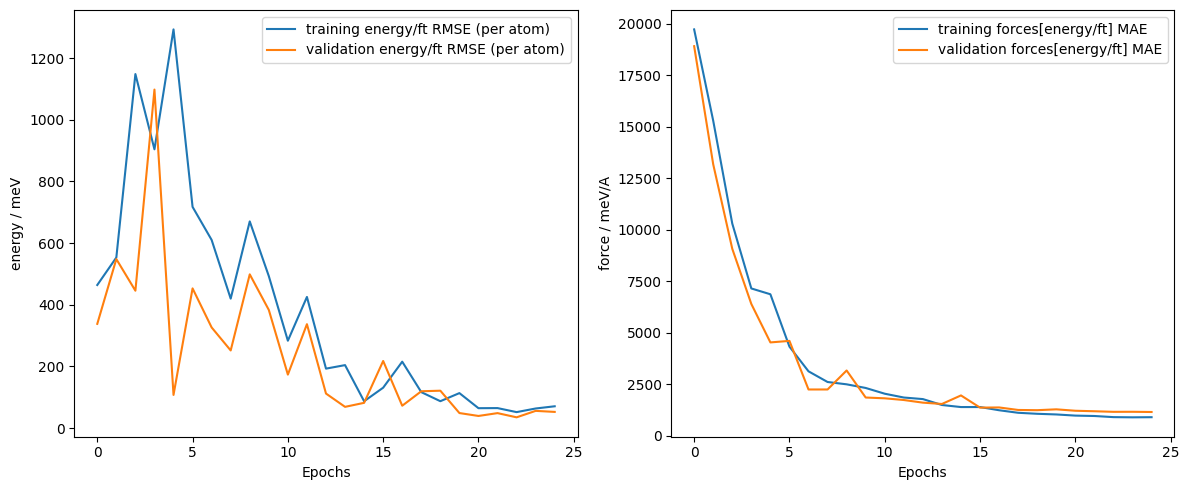

In [42]:
training_energy_RMSE = structured["training energy/ft RMSE (per atom)"]
training_forces_MAE = structured["training forces[energy/ft] MAE"]
validation_energy_RMSE = structured["validation energy/ft RMSE (per atom)"]
validation_forces_MAE = structured["validation forces[energy/ft] MAE"]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(training_energy_RMSE, label="training energy/ft RMSE (per atom)")
axs[0].plot(validation_energy_RMSE, label="validation energy/ft RMSE (per atom)")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("energy / meV")
axs[0].legend()
axs[1].plot(training_forces_MAE, label="training forces[energy/ft] MAE")
axs[1].plot(validation_forces_MAE, label="validation forces[energy/ft] MAE")
axs[1].set_ylabel("force / meV/A")
axs[1].set_xlabel("Epochs")
axs[1].legend()
plt.tight_layout()
plt.show()

In [16]:
targets = ase.io.read("/Users/markusfasching/EPFL/Work/metatrain/tests/resources/ethanol_reduced_100.xyz", format='extxyz', index=':')
predictions_ft = ase.io.read("output.xyz", format='extxyz', index=':')
predictions_petmad = ase.io.read("output-petmad.xyz", format='extxyz', index=':')

calc_ft = MetatomicCalculator('model.pt', variants={"energy": "ft"})
calc_petmad = MetatomicCalculator('pet-mad-v1.1.0.pt')

e_targets = np.array(
    [frame.get_total_energy() / len(frame) for frame in targets]
)  # target energies
f_targets = np.array(
    [frame.get_forces().flatten() for frame in targets]
).flatten()  # target forces

for frame in targets:
    frame.set_calculator(calc_ft)

e_predictions = np.array(
    [frame.get_total_energy() / len(frame) for frame in targets]
)  # predicted energies
f_predictions = np.array(
    [frame.get_forces().flatten() for frame in targets]
).flatten()  # predicted forces

for frame in targets:
    frame.set_calculator(calc_petmad)
e_predictions_petmad = np.array(
    [frame.get_total_energy() / len(frame) for frame in targets]
)  # predicted energies

f_predictions_petmad = np.array(
    [frame.get_forces().flatten() for frame in targets]
).flatten()  # predicted forces



[W1119 19:49:58.046003000 model.cpp:232] Warning: 'energy' defines 3 output variants and 'energy' has an empty description. Consider adding meaningful descriptions helping users to distinguish between them. (function set_outputs)
[W1119 19:49:58.046025000 model.cpp:232] Warning: 'energy' defines 3 output variants and 'energy/ft' has an empty description. Consider adding meaningful descriptions helping users to distinguish between them. (function set_outputs)
[W1119 19:49:58.046030000 model.cpp:232] Warning: 'energy' defines 3 output variants and 'mtt::aux::energy/ft_last_layer_features' has an empty description. Consider adding meaningful descriptions helping users to distinguish between them. (function set_outputs)
[W1119 19:49:58.114848000 misc.cpp:101] Warning: Model requested device 'cuda' (cuda) but it's not available; ignoring. (function pick_device)
[W1119 19:49:58.362340000 misc.cpp:101] Warning: Model requested device 'cuda' (cuda) but it's not available; ignoring. (function p

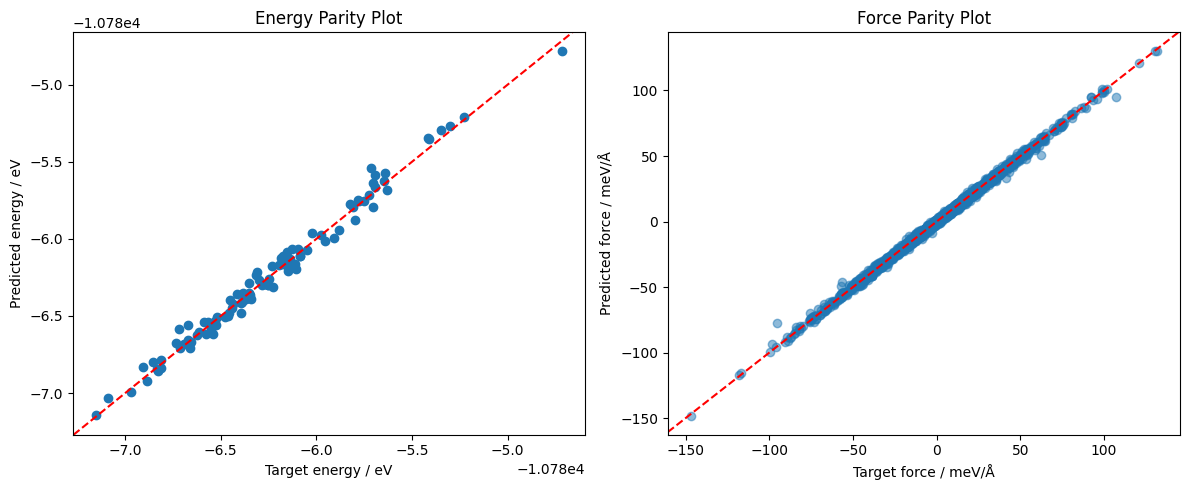

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Parity plot for energies
axs[0].scatter(e_targets, e_predictions, label='FT')
#axs[0].scatter(e_targets, e_predictions_petmad, label='PET-MAD')
axs[0].axline((np.min(e_targets), np.min(e_targets)), slope=1, ls="--", color="red")
axs[0].set_xlabel("Target energy / meV")
axs[0].set_ylabel("Predicted energy / meV")
min_e = np.min(np.array([e_targets, e_predictions])) - 2
max_e = np.max(np.array([e_targets, e_predictions])) + 2
#axs[0].set_xlim([min_e, max_e])
#axs[0].set_ylim([min_e, max_e])
axs[0].set_title("Energy Parity Plot")

# Parity plot for forces
axs[1].scatter(f_targets, f_predictions, alpha=0.5, label='FT')
#axs[1].scatter(f_targets, f_predictions_petmad, alpha=0.5, label='PET-MAD')
axs[1].axline((np.min(f_targets), np.min(f_targets)), slope=1, ls="--", color="red")
axs[1].set_xlabel("Target force / meV/Å")
axs[1].set_ylabel("Predicted force / meV/Å")
min_f = np.min(np.array([f_targets, f_predictions])) - 2
max_f = np.max(np.array([f_targets, f_predictions])) + 2
#axs[1].set_xlim([min_f, max_f])
##axs[1].set_ylim([min_f, max_f])
axs[1].set_title("Force Parity Plot")

fig.tight_layout()
plt.show()